In [581]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

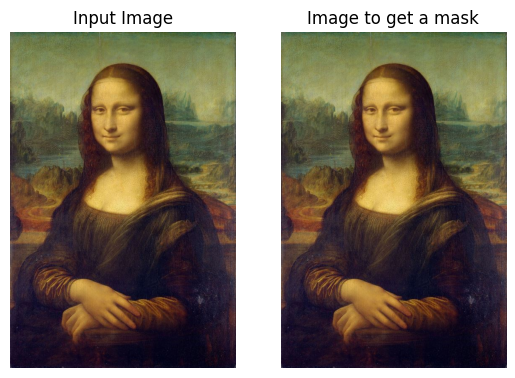

In [719]:
input_image_path = "monalisa.jpeg" 
mask_image_path = "monalisa.jpeg" 

input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(input_image_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.title('Image to get a mask')
plt.axis('off')  # Turn off axis labels
plt.show()


In [720]:
def getMask(mask_image):
    # Get the ROI using cv2.selectROI
    rect_roi = cv2.selectROI(mask_image)
    cv2.destroyAllWindows()

    return input_image[int(rect_roi[1]):int(rect_roi[1]+rect_roi[3]),
                int(rect_roi[0]):int(rect_roi[0]+rect_roi[2])] 

def getRegionToMask(input_image):
    rect_roi = cv2.selectROI(input_image)
    cv2.destroyAllWindows()

    return rect_roi

def setMaskImage(mask_image, region_to_mask, mask):   

    # Create a white image
    result_image = np.copy(mask_image)

    # Calculate the center of the region_to_mask
    center_x = int(region_to_mask[0] + region_to_mask[2] / 2)
    center_y = int(region_to_mask[1] + region_to_mask[3] / 2)

    # Calculate the position to place the mask in the new image
    start_x = center_x - int(mask.shape[1] / 2)
    start_y = center_y - int(mask.shape[0] / 2)

    # Create a new image with the mask placed in the specified region
    result_image[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = mask

    # Create mask for blending image as black and white
    mask_for_blending = np.zeros_like(mask_image, dtype=float)
    mask_for_blending[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = 1
    return result_image, mask_for_blending

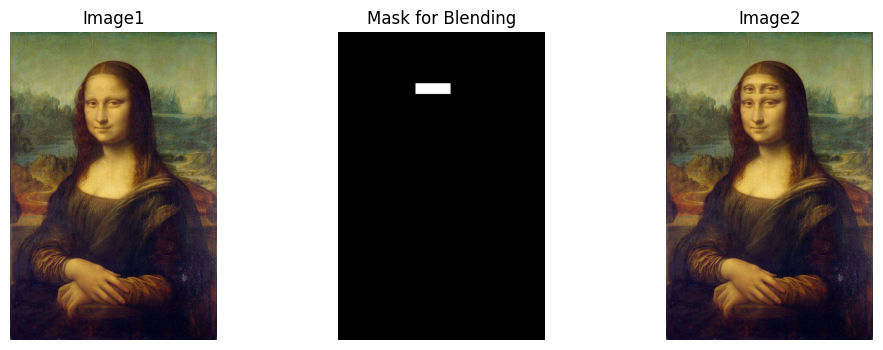

In [721]:
# Get the mask from the mask image (second image)
mask = getMask(mask_image)

# Get the region to mask from input image (first image)
region_to_mask = getRegionToMask(input_image)

image1 = input_image
image2, mask_for_blending = setMaskImage(mask_image, region_to_mask, mask)

#mask_for_blending = np.zeros_like(input_image[:, :, 0]) 

#mask_for_blending[int(region_to_mask[1]):int(region_to_mask[1] + region_to_mask[3]),
 #    int(region_to_mask[0]):int(region_to_mask[0] + region_to_mask[2])] = 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title("Image1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_for_blending, cmap='gray')
plt.title("Mask for Blending")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image2, cmap='gray')
plt.title("Image2")
plt.axis('off')

plt.show()

### GET LAPLACIAN PYRAMIDS OF EACH IMAGES

In [774]:
def downsample(image):
    return cv2.resize(image, None, fx=1/2, fy=1/2)

def upsample(image):
    return cv2.resize(image, (image.shape[1] * 2, image.shape[0] * 2), interpolation=cv2.INTER_LINEAR)


In [775]:
pyramid_level = 3

In [776]:
# Convert images to grayscale, this is because normalizing the image and not let values exceeds the limit of 0,255 range
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) / 255.0
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY) / 255.0
#gray_mask_for_blending = cv2.cvtColor(mask_for_blending, cv2.COLOR_BGR2GRAY) / 255.0

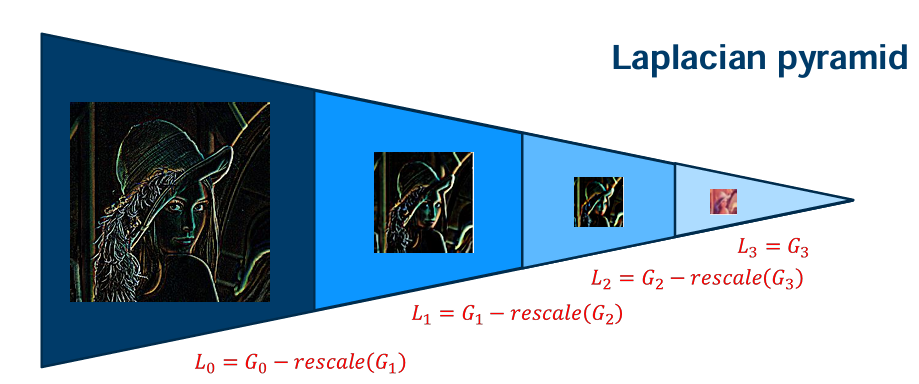

In [814]:
def normalize_image(image):
    # Normalize the image values to be in the range [0, 255]
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_image.astype(np.uint8)

def blur_image(image):
    return cv2.GaussianBlur(image, (5, 5), 1.6)

def subtract_images(original, blurred):
    return original - blurred

def laplacian(image, levels):
    images = [image]
    laplacian_images = []

    for level in range(levels):
        if level < levels - 1:
            blurred_image = blur_image(images[-1])
            residual = subtract_images(images[-1], blurred_image)
            laplacian_images.append(residual)
            downsampled_image = downsample(blurred_image)
            images.append(downsampled_image)
        else:
            laplacian_images.append(normalize_image(images[-1]))

    return laplacian_images

In [837]:
L1 = laplacian(image1, pyramid_level)
L2 = laplacian(image2, pyramid_level)

In [838]:
L1[0].min()

0

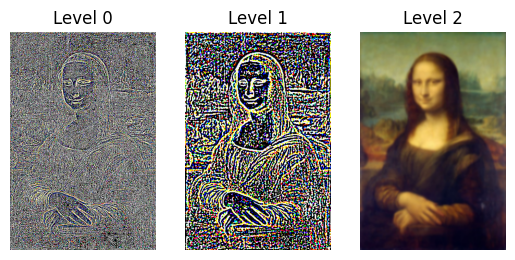

In [839]:
# Display Laplacian images level by level
for i, laplacian_image in enumerate(L1):
    plt.subplot(1, len(L1), i + 1)
    plt.imshow(laplacian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

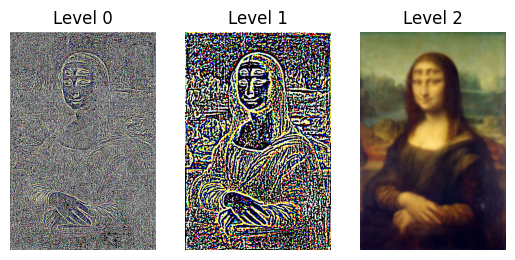

In [818]:
# Display Laplacian images level by level
for i, laplacian_image in enumerate(L2):
    plt.subplot(1, len(L2), i + 1)
    plt.imshow(laplacian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

## Gaussian Pyramid for Each Region Mask

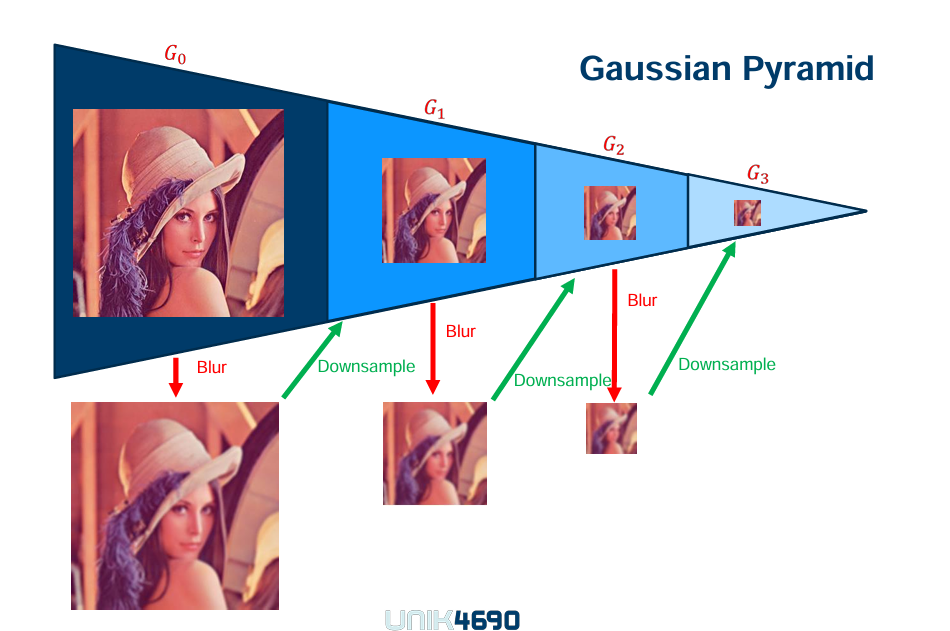

In [880]:
def downsample(image):
    return cv2.resize(image, None, fx=1/2, fy=1/2)

In [881]:
def gaussian (image, levels):
    images = [image]
    for level in range(levels):
        blurred_image = cv2.GaussianBlur(image,(19,19),0) 
        downsampled_image = downsample(blurred_image)
        images.append(downsampled_image)
        image = downsampled_image
    return images

(800, 537, 3)
(400, 268, 3)
(200, 134, 3)
(100, 67, 3)


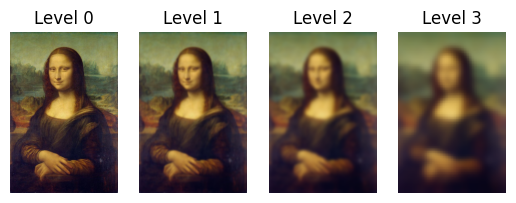

In [882]:
R1 = gaussian(image1 , pyramid_level)
# Display Laplacian images level by level
for i, gaussian_image in enumerate(R1):
    #R[i] = np.expand_dims(R[i], axis=-1)
    print(gaussian_image.shape)
    plt.subplot(1, len(R1), i + 1)
    plt.imshow(gaussian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

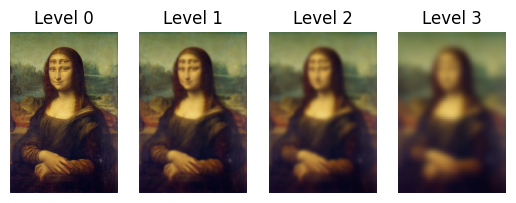

In [883]:
R2 = gaussian(image2 , pyramid_level)
# Display Laplacian images level by level
for i, gaussian_image in enumerate(R2):
    #R[i] = np.expand_dims(R[i], axis=-1)
    plt.subplot(1, len(R2), i + 1)
    plt.imshow(gaussian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

In [884]:
def laplacian_pyramid(gaussian_pyramid):
    laplacian_images = []
    for i in range(len(gaussian_pyramid) - 1):
        original_shape = gaussian_pyramid[i].shape[:2]
        expanded_image = cv2.resize(gaussian_pyramid[i + 1], (original_shape[1], original_shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i], expanded_image)
        laplacian_images.append(laplacian)
    laplacian_images.append(gaussian_pyramid[-1])  # The last level is the same in Laplacian pyramid
    return laplacian_images

In [886]:
L1 = laplacian_pyramid(R1)
L2 = laplacian_pyramid(R2)

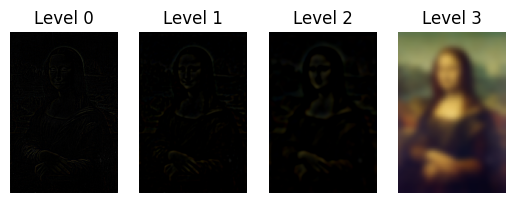

In [887]:
# Display Laplacian images level by level
for i, gaussian_image in enumerate(L1):
    #R[i] = np.expand_dims(R[i], axis=-1)
    plt.subplot(1, len(L1), i + 1)
    plt.imshow(gaussian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

In [888]:
R = gaussian(mask_for_blending , pyramid_level)

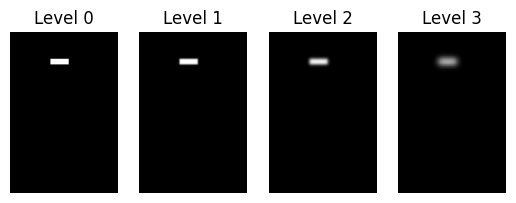

In [889]:
# Display Laplacian images level by level
for i, gaussian_image in enumerate(R):
    #R[i] = np.expand_dims(R[i], axis=-1)
    plt.subplot(1, len(R), i + 1)
    plt.imshow(gaussian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

### BLEND EACH IMAGE

In [890]:
def resize_image(image, target_shape):
    return cv2.resize(image, target_shape)

In [891]:
def blend_laplacian_pyramids(L1, L2, R):
    blended_pyramid = []

    for i in range(len(L1)):
        blended_level = np.clip(L1[i] * R[i] + L2[i] * (1 - R[i]), 0, 255)
        blended_pyramid.append(blended_level)

    return blended_pyramid

In [902]:
def blend_laplacian_pyramids(LA, LB, GR):


    depth = pyramid_level

    # # 1) Combine the Laplacian pyramids of the two images.
    # #    For every level d, and every pixel (i,j) the output for the 
    # #    combined Laplacian pyramid is of the form:
    # #    LS(d,i,j) = GR(d,i,j)*LA(d,i,j) + (1-GR(d,i,j))*LB(d,i,j)
    LS = np.empty((depth-1), dtype=object)
    for d in range(depth-1):
      LS[d] = GR[d]*LA[d] + (1-GR[d])*LB[d]

      
    return LS

In [903]:
blended_pyramid = blend_laplacian_pyramids(L1, L2, R)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


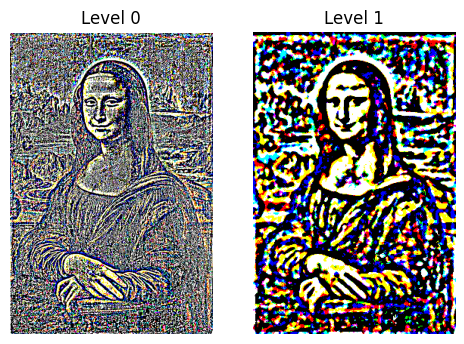

In [904]:
# Display Laplacian images level by level
plt.figure(figsize=(12, 4))
for i, gaussian_image in enumerate(blended_pyramid):
    plt.subplot(1, len(R), i + 1)
    plt.imshow(gaussian_image, cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

In [895]:
def collapse(laplacian_pyramid):
    """
    This function collapses the input laplacian pyramid and returns the
    recovered image

    Input:
    laplacian_pyramid: the Laplacian pyramid of an image
    Output:
    I: The Recovered image from the Laplacian pyramid
    """
    # print(laplacian_pyramid.shape)

    G = np.empty((pyramid_level), dtype=object)
    G[-1] = laplacian_pyramid[-1]
    for i in range(2, pyramid_level+1):
      G[-i] = laplacian_pyramid[-i] + upsample(G[-i+1])
    I = G[0]

    # 1) Recover the image that is encoded in the Laplacian pyramid
  
    return I

In [896]:
def upsample2(image, target_shape):
    return cv2.resize(image, target_shape)

def collapse_laplacian_pyramid(blended_pyramid):
    blended_image = blended_pyramid[-1]

    for i in range(len(blended_pyramid) - 2, -1, -1):
        blended_image_resized = resize_image(blended_image, blended_pyramid[i].shape[:2])
        blended_level_upsampled = upsample2(blended_pyramid[i + 1], blended_image_resized.shape[:2])
        blended_image = blended_pyramid[i] + blended_level_upsampled

    return blended_image



In [897]:
final_blended_image = collapse_laplacian_pyramid(blended_pyramid)
final_blended_image.shape

(800, 537, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 536.5, 799.5, -0.5)

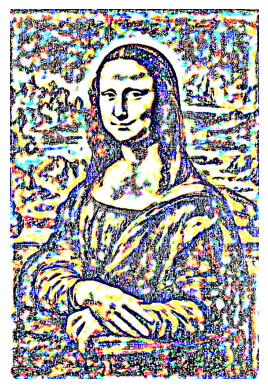

In [899]:
plt.imshow(final_blended_image)
plt.axis('off')